# POS Tagging with LSTM

In this notebook, I will use a LSTM to predict the POS tags of words in a sentence. In order to do so we will use the `MyTagger` class. This class will be responsible for training the model and predicting the POS tags of a sentence. 


In [1]:
from tagger import MyTagger

2024-11-05 11:58:36.297374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## English POS Tags

We will start with a firts model that will predict the POS tags of a sentence in English, using use the dataset from the [UD English EWT](https://github.com/UniversalDependencies/UD_English-EWT).

### Initial set up

#### Creating the tagger

The `MyTagger` class will be initialized with the three files in CoNLL-U format that contain the training, validation and test data. In this way, we can have one instance of the class for each language.

In [2]:
eng_tagger = MyTagger(
    train_filename = "data/english/en_ewt-ud-train.conllu",
    val_filename = "data/english/en_ewt-ud-dev.conllu",
    test_filename = "data/english/en_ewt-ud-test.conllu"
)

#### Max sentence length

We need to make some decisions regarding the model's parameters. For example, we should define the maximum sentence length in the dataset and the size of the vocabulary. Below, we present some statistics about the dataset. It is important to note that this analysis is based solely on the training dataset, as we should not use the validation or test sets for this purpose. Using information from those sets to inform model design could lead to biased results.

We should make a decission about the maximum length of the sentences. We observe that the average length of the sentences is aproximately 16 words and the standard deviation is 12.4. Also, we observe that there are not a lot of sentences with more than 100 words (only 0.04% of the sentences).

Max sentence length: 159
Mean sentence length: 16.31
Standard deviation of sentence length: 12.4


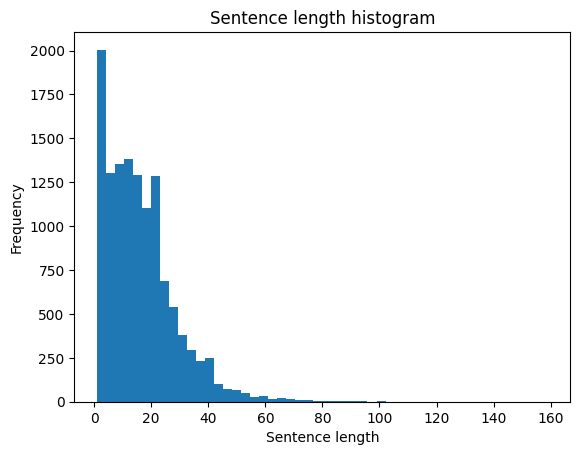

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the maximum length of the sentences
sentence_num_words = [len(sentence.split()) for sentence in eng_tagger.X_train]
max_len = max(sentence_num_words)
print(f"Max sentence length: {round(max_len, 2)}")

mean_len = np.mean(sentence_num_words)
std_len = np.std(sentence_num_words)
print(f"Mean sentence length: {round(mean_len, 2)}")
print(f"Standard deviation of sentence length: {round(std_len, 2)}")

# Build an histogram of the number of words in the sentences
plt.hist(sentence_num_words, bins=50)
plt.xlabel("Sentence length")
plt.ylabel("Frequency")
plt.title("Sentence length histogram")
plt.show()

In [4]:
max_sentence_num_words = 100
sentences_over_max_length = [i for i, num_words in enumerate(sentence_num_words) if num_words > max_sentence_num_words]
print(f"Number of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length)}")
print(
    f"Percentage of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length) / len(eng_tagger.X_train) * 100:.2f}%\n"
)

for i in sentences_over_max_length:
    print(
        f'Sentence {i} has more than {max_sentence_num_words} words ({sentence_num_words[i]}). Sentence: "{eng_tagger.X_train[i]}"'
)

Number of sentences over 100 words: 5
Percentage of sentences over 100 words: 0.04%

Sentence 6090 has more than 100 words (102). Sentence: "That is what is about to happen with Judge Samuel Alito , in my opinion , because he has one tragic flaw - a very serious blind spot in his thinking - which makes him completely unacceptable for the position of Supreme Court Justice : He does not really agree with the system of " Checks and Balances " built into the Constitution , and he is ready to start tearing it down in order to follow the " Unitary Executive Theory , " which calls for vastly - increased Presidential Power at the expense of Congress and the Supreme Court ."
Sentence 6470 has more than 100 words (104). Sentence: "" I do not feel it has changed the US citizens which is what was needed , even now the majority want " Gas " despite the fact they are polluting the world more than any other country in the world and refuse to stop , perhaps this natural disaster , which let 's face it

As there are only few sentences with more than 100 words, we decide to set the maximum length of the sentences to 100. We will pad the sentences with zeros if they are shorter than 100 words and we will truncate them if they are longer than 100 words. To truncate them we have to options:

- Truncate the sentences from the end of the sentence.
- Locate the last punctuation mark before the token 100 and truncate the sentence from there.


In [5]:
from utils import locate_last_punctuation_mark

for i in sentences_over_max_length:
    print(f"Last punctuation mark in sentence {i}: {locate_last_punctuation_mark(eng_tagger.y_train[i], limit=100)}")

Last punctuation mark in sentence 6090: 88
Last punctuation mark in sentence 6470: 93
Last punctuation mark in sentence 6724: 84
Last punctuation mark in sentence 6779: 92
Last punctuation mark in sentence 7506: -1


As not all the sentences that overlap the 100 words limit have a punctuation mark before the 100th token, we decide to truncate the sentences from the last punctuation mark before the 100th token, in case there is one. If there is no punctuation mark before the 100th token, we truncate the sentence from the 100th token.

We must do this for the training, validation and test sets. This can be done by calling the `preprocess_data` method of the `MyTagger` class. By specifying `with_punctuation=True` and `max_sentence_num_words = 100` as arguments, the method will truncate the sentences from the last punctuation mark before the 100th token. If there is no punctuation mark before the 100th token, the sentence will be truncated from the 100th token. 

The preprocessing includes truncating the sentences and padding them with zeros after the truncation. The same will be done for the labels.


In [6]:
eng_tagger.preprocess_data(max_sentence_num_words=100, with_punctuation=True)

In [7]:
print(f"Sentence 1: {eng_tagger.X_train[0]}")
print(f"Label 1: {eng_tagger.y_train[0]}")

Sentence 1: Al - Zaman : American forces killed Shaikh Abdullah al - Ani , the preacher at the mosque in the town of Qaim , near the Syrian border .
Label 1: [12 13 12 13  1  8 16 12 12 12 13 12 13  6  8  2  6  8  2  6  8  2 12 13
  2  6  1  8 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


### Trying a first model

We calculated the number of unique words in the training and test sets, which are 19,674 and 5,629, respectively. Half of the words of the test set are not present in the training set. This suggests that it may not be necessary to include all the words from the training set in the vocabulary, as this likely won't impact the model's performance. To determine the optimal vocabulary size, we also analyzed the frequency distribution of words in the training set. We found that only 9,868 words appear more than once in the training set, while the remaining 9,806 words appear only once. This suggests that we could set the vocabulary size to 10,000 without losing much information.


In [8]:
X_plain_train = {token for sentence in eng_tagger.X_train for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_train)}")

X_plain_test = {token for sentence in eng_tagger.X_test for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_test)}")

tokens_train_in_test = X_plain_train.intersection(X_plain_test)
print(f"Number of tokens in train set that are also in test set: {len(tokens_train_in_test)}")

Number of unique tokens: 19671
Number of unique tokens: 5629
Number of tokens in train set that are also in test set: 3793


In [9]:
from utils import calculate_word_frequency

frequencies = calculate_word_frequency(eng_tagger.X_train)

# We count the number of words with more than 1, 2 and 3 occurrences
num_words_gt_1 = sum(1 for word, freq in frequencies.items() if freq > 1)
num_words_gt_2 = sum(1 for word, freq in frequencies.items() if freq > 2)
num_words_gt_3 = sum(1 for word, freq in frequencies.items() if freq > 3)

print(f"Number of words with more than 1 occurrence: {num_words_gt_1}")
print(f"Number of words with more than 2 occurrences: {num_words_gt_2}")
print(f"Number of words with more than 3 occurrences: {num_words_gt_3}")

Number of words with more than 1 occurrence: 9868
Number of words with more than 2 occurrences: 6727
Number of words with more than 3 occurrences: 5142


In this way, we start by building a simple model with the following architecture:
- `Vocabulary size`: 10,000
- `Embedding size`: 50
- `LSTM units`: 64
- `Bidirectional`: False  

In [10]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 64, 
#     output_dim = 50, 
#     bidirectional = False
# )

# To load the same model already trained
eng_tagger.load_model("initial_model")
eng_tagger.model.summary()

Model loaded from ./models/initial_model.keras
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 lstm (LSTM)                 (None, 100, 64)           29440     
                                                                 
 time_distributed (TimeDist  (None, 100, 18)           1170      
 ributed)                                                        
                                                                 
Total params: 

And we perform a first training with the following hyperparameters:
- `Batch size`: 64
- `Epochs`: 10
- `Optimizer`: Adam

In [11]:
# To train the model
# eng_tagger.train(
#     batch_size = 64, 
#     optimizer = "adam",
#     metrics=["accuracy"]
# )

# To show the training history of the model already trained
eng_tagger.show_training_log()

Epoch 1/11 - Loss: 1.9551, Accuracy: 0.4382, Val Loss: 0.9629, Val Accuracy: 0.7162
Epoch 2/11 - Loss: 0.5628, Accuracy: 0.8457, Val Loss: 0.4646, Val Accuracy: 0.8711
Epoch 3/11 - Loss: 0.3005, Accuracy: 0.9149, Val Loss: 0.3825, Val Accuracy: 0.8866
Epoch 4/11 - Loss: 0.2332, Accuracy: 0.9280, Val Loss: 0.3596, Val Accuracy: 0.8914
Epoch 5/11 - Loss: 0.2012, Accuracy: 0.9346, Val Loss: 0.3551, Val Accuracy: 0.8914
Epoch 6/11 - Loss: 0.1805, Accuracy: 0.9405, Val Loss: 0.3479, Val Accuracy: 0.8932
Epoch 7/11 - Loss: 0.1649, Accuracy: 0.9448, Val Loss: 0.3515, Val Accuracy: 0.8943
Epoch 8/11 - Loss: 0.1519, Accuracy: 0.9492, Val Loss: 0.3496, Val Accuracy: 0.8949
Epoch 9/11 - Loss: 0.1408, Accuracy: 0.9532, Val Loss: 0.3576, Val Accuracy: 0.8951
Epoch 10/11 - Loss: 0.1314, Accuracy: 0.9565, Val Loss: 0.3711, Val Accuracy: 0.8914
Epoch 11/11 - Loss: 0.1227, Accuracy: 0.9595, Val Loss: 0.3787, Val Accuracy: 0.8932


We can represent the training process in a graph with the following method. In this way, we can see the evolution of the loss and accuracy in the training and validation sets. The results show that the model is overfitting, as the loss in the validation starts to increase after the fifth epoch, which is a sign of overfitting. Thanks to the early stopping, the saved model is the one with the best performance in the validation set.

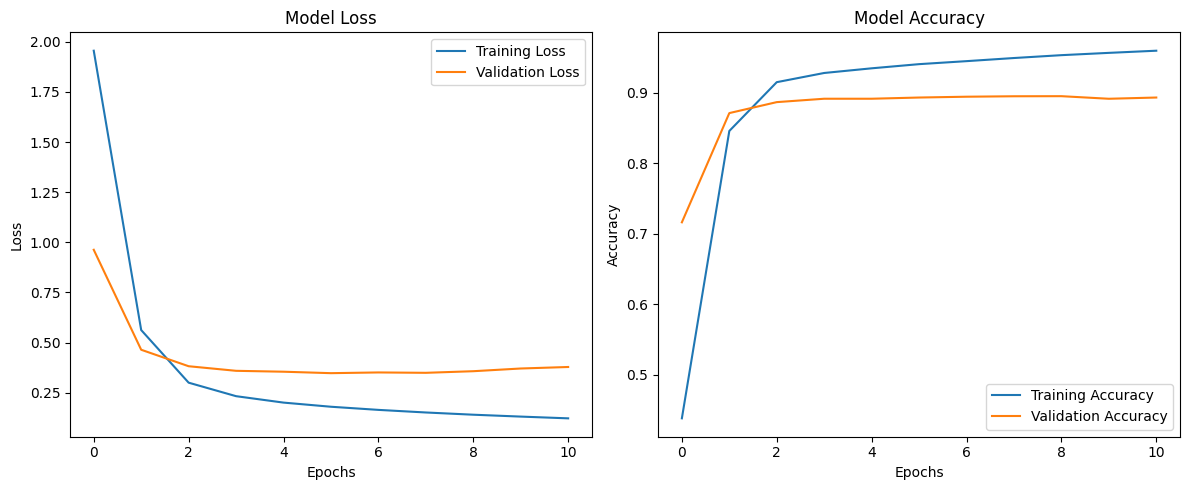

In [12]:
eng_tagger.plot_training_history()

We can, now, evaluate the model performance over the test set. The results show that the model has an accuracy of 0.8986, a result that could be better. Another possibility is to predict a new sentence and see the tags predicted by the model for each one of the words.

In [13]:
eng_tagger.evaluate()
predictions = eng_tagger.predict("I am a sentence .")

1/1 [==============================] - 1s 1s/step
Prediction for 'I am a sentence .':
	I -> PRON
	am -> AUX
	a -> DET
	sentence -> NOUN
	. -> PUNCT


By analyzing the confussion matrix we can see that the model has some difficulties in predicting the tags of some words. The tag 'X', for others, is never predicted correctly as these are strange words with few representation.  'NOUN' presents problems with other tags like 'ADJ', 'VERB' or 'PROPN'. However, 'NOUN' is the most frequent tag in the dataset, which may explain the high number of errors in this class. The main problem is the confusion between 'NOUN' and 'PROPN' tags, as 'PROPN' presents a high number of errors related to the 'NOUN' tag, while the frequency of 'PROPN' is similar to the frequency of 'ADJ' and 'VERB' tags. 'PROPN' and 'NOUN' are classes that can appear in similar positions within a sentence and may have similar inflectional forms, leading to confusion in classification.

65/65 [==============================] - 1s 16ms/step


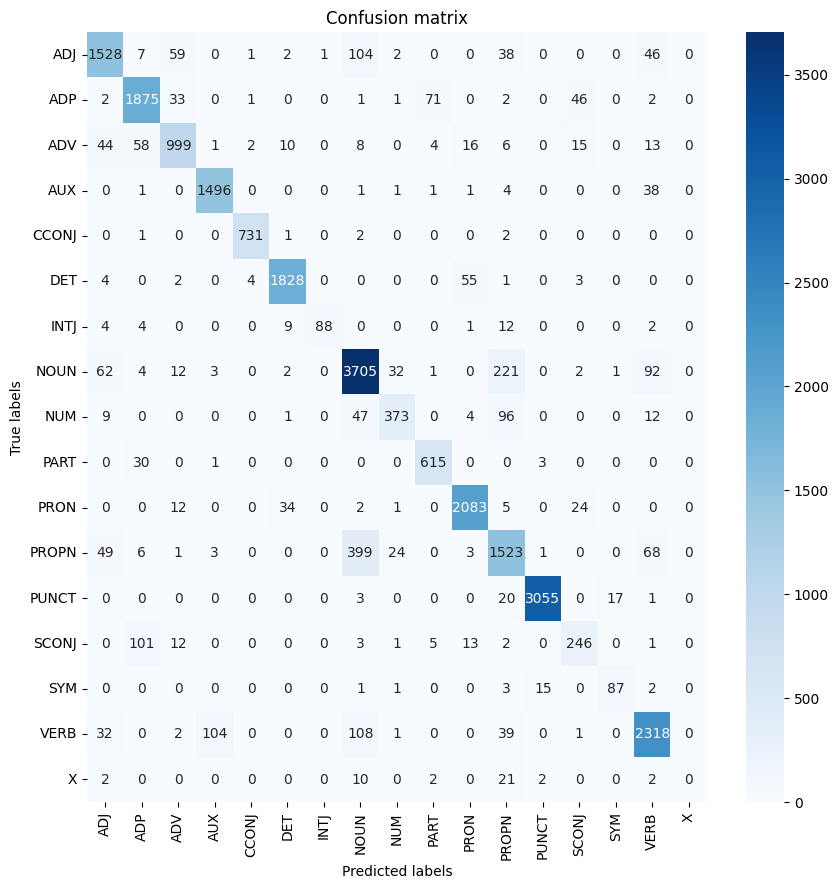

In [14]:
eng_tagger.plot_confusion_matrix()

In [ ]:
from collections import Counter

tag_frequencies = Counter(tag for sentence in eng_tagger.y_test for tag in sentence)
for tag, freq in tag_frequencies.items():
    print(f"{eng_tagger.index_to_tag[tag]}: {freq}")

PRON: 2161
SCONJ: 384
PROPN: 2077
VERB: 2605
ADP: 2034
PUNCT: 3096
PAD: 182606
NOUN: 4137
CCONJ: 737
ADV: 1176
DET: 1897
ADJ: 1788
AUX: 1543
PART: 649
NUM: 542
SYM: 109
INTJ: 120
X: 39


Finally, we can save the model and the training results in a file. This way, we can load the model and the training results in the future without having to train the model again.

In [8]:
eng_tagger.save_model(model_filename = "initial_model")

Model saved in ./models/initial_model.keras
Training history saved in ./models/initial_model_training_history.json


### Adding a bidirectional layer

As we have seen some overfitting in the previous model, we can try to add a bidirectional layer to the model. This way, the model will be able to learn from the context of the words in both directions. This may improve results in training and validation sets.

In [17]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 64, 
#     output_dim = 50, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("bidirectional_model")


# To train the model
# eng_tagger.train( 
#     batch_size = 64, 
#     optimizer = "adam",
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/bidirectional_model.keras
Epoch 1/11 - Loss: 1.7743, Accuracy: 0.4802, Val Loss: 0.6722, Val Accuracy: 0.8194
Epoch 2/11 - Loss: 0.3790, Accuracy: 0.8980, Val Loss: 0.3512, Val Accuracy: 0.9000
Epoch 3/11 - Loss: 0.2055, Accuracy: 0.9411, Val Loss: 0.3024, Val Accuracy: 0.9069
Epoch 4/11 - Loss: 0.1561, Accuracy: 0.9535, Val Loss: 0.2866, Val Accuracy: 0.9138
Epoch 5/11 - Loss: 0.1297, Accuracy: 0.9607, Val Loss: 0.2840, Val Accuracy: 0.9146
Epoch 6/11 - Loss: 0.1115, Accuracy: 0.9662, Val Loss: 0.2810, Val Accuracy: 0.9164
Epoch 7/11 - Loss: 0.0971, Accuracy: 0.9708, Val Loss: 0.2918, Val Accuracy: 0.9143
Epoch 8/11 - Loss: 0.0843, Accuracy: 0.9751, Val Loss: 0.2968, Val Accuracy: 0.9146
Epoch 9/11 - Loss: 0.0739, Accuracy: 0.9788, Val Loss: 0.3149, Val Accuracy: 0.9144
Epoch 10/11 - Loss: 0.0649, Accuracy: 0.9816, Val Loss: 0.3176, Val Accuracy: 0.9152
Epoch 11/11 - Loss: 0.0573, Accuracy: 0.9842, Val Loss: 0.3323, Val Accuracy: 0.9136


The accuracy in test set has improved to 0.9221, i.e., 0.03 higher than the previous model, so the bidirectional layer has improved the model performance. However, there is still some overfitting, as the loss in the validation set starts to increase after the fifth epoch.

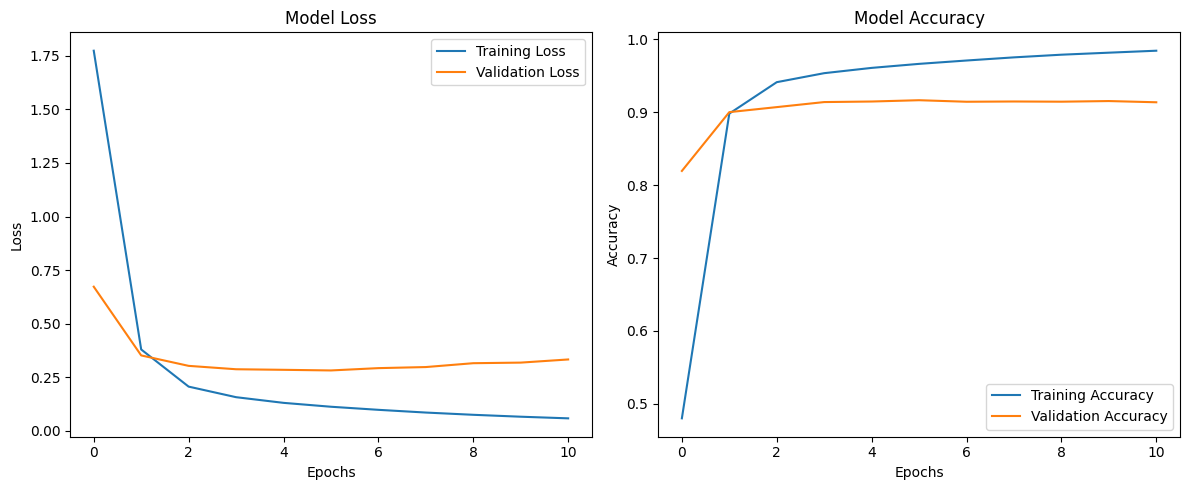

65/65 [==============================] - 8s 21ms/step - loss: 0.2598 - accuracy: 0.9221


In [18]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [19]:
eng_tagger.save_model(model_filename = "bidirectional_model")

Model saved in ./models/bidirectional_model.keras
Training history saved in ./models/bidirectional_model_training_history.json


We can compare the results on both models by plotting the loss in the training and validation sets for both models. We see that the difference between the loss in the training and validation sets is the same in both models, but the loss in the bidrectional reduces for both sets.

In [ ]:
from utils import add_curve
%matplotlib inline
fig = add_curve(json_file = "models/initial_model_training_history.json", name = "initial model", color = "blue", title = "Adding bidirectional layer")
fig = add_curve(json_file = "models/bidirectional_model_training_history.json", name = "bidirectional", color = "green", fig = fig)
fig.show()

The loss and accuracy improves in the bidirectional model for the test set, as we can see in the following table. In this way, we will choose the bidirectional model over the previous one.

|                       | **Acccuracy** | **Loss** |
|:---------------------:|:-------------:|:--------:|
|    _Initial model_    |     0.8986    |  0.3324  |
| _Bidirectional model_ |     0.9221    |  0.2598  |

### Number of LSTM units

As we have seen some overfitting in the previous models, we can try to reduce the number of LSTM units to 32. This way, the model will have less parameters and may reduce overfitting.

In [21]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 32, 
#     output_dim = 50, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("units32")

# To train the model
# eng_tagger.train(
#     batch_size = 64, 
#     optimizer = "adam",
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/units32.keras
Epoch 1/11 - Loss: 1.9461, Accuracy: 0.4465, Val Loss: 0.8581, Val Accuracy: 0.7887
Epoch 2/11 - Loss: 0.4793, Accuracy: 0.8833, Val Loss: 0.3980, Val Accuracy: 0.8898
Epoch 3/11 - Loss: 0.2455, Accuracy: 0.9352, Val Loss: 0.3265, Val Accuracy: 0.9054
Epoch 4/11 - Loss: 0.1844, Accuracy: 0.9482, Val Loss: 0.3055, Val Accuracy: 0.9113
Epoch 5/11 - Loss: 0.1540, Accuracy: 0.9555, Val Loss: 0.2971, Val Accuracy: 0.9122
Epoch 6/11 - Loss: 0.1337, Accuracy: 0.9609, Val Loss: 0.2911, Val Accuracy: 0.9151
Epoch 7/11 - Loss: 0.1176, Accuracy: 0.9656, Val Loss: 0.2932, Val Accuracy: 0.9152
Epoch 8/11 - Loss: 0.1043, Accuracy: 0.9700, Val Loss: 0.2951, Val Accuracy: 0.9170
Epoch 9/11 - Loss: 0.0927, Accuracy: 0.9734, Val Loss: 0.2949, Val Accuracy: 0.9164
Epoch 10/11 - Loss: 0.0828, Accuracy: 0.9771, Val Loss: 0.3048, Val Accuracy: 0.9161
Epoch 11/11 - Loss: 0.0743, Accuracy: 0.9796, Val Loss: 0.3164, Val Accuracy: 0.9152


By reducing the number of units from to 64 to 32 we don't see any improvement in the model performance and the results are slightly worse than the previous model.

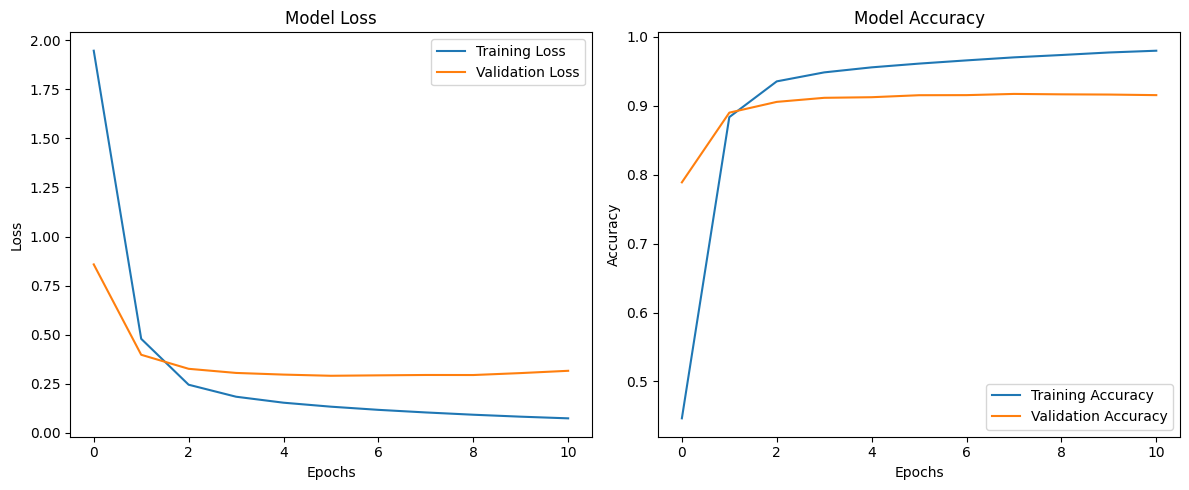

65/65 [==============================] - 7s 23ms/step - loss: 0.2736 - accuracy: 0.9191


In [22]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [15]:
eng_tagger.save_model(model_filename = "units32")

Model saved in ./models/units32.keras
Training history saved in ./models/units32_training_history.json


We will try to reduce the number of units to 16.

In [23]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 16, 
#     output_dim = 50, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("units16")

# To train the model
# eng_tagger.train(
#     batch_size = 64, 
#     optimizer = "adam",
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/units16.keras
Epoch 1/16 - Loss: 2.1687, Accuracy: 0.3757, Val Loss: 1.2302, Val Accuracy: 0.7008
Epoch 2/16 - Loss: 0.7187, Accuracy: 0.8355, Val Loss: 0.5205, Val Accuracy: 0.8707
Epoch 3/16 - Loss: 0.3489, Accuracy: 0.9179, Val Loss: 0.3926, Val Accuracy: 0.8906
Epoch 4/16 - Loss: 0.2468, Accuracy: 0.9358, Val Loss: 0.3492, Val Accuracy: 0.8989
Epoch 5/16 - Loss: 0.2015, Accuracy: 0.9444, Val Loss: 0.3266, Val Accuracy: 0.9067
Epoch 6/16 - Loss: 0.1748, Accuracy: 0.9503, Val Loss: 0.3189, Val Accuracy: 0.9055
Epoch 7/16 - Loss: 0.1563, Accuracy: 0.9550, Val Loss: 0.3085, Val Accuracy: 0.9094
Epoch 8/16 - Loss: 0.1409, Accuracy: 0.9591, Val Loss: 0.3048, Val Accuracy: 0.9111
Epoch 9/16 - Loss: 0.1283, Accuracy: 0.9634, Val Loss: 0.3046, Val Accuracy: 0.9111
Epoch 10/16 - Loss: 0.1169, Accuracy: 0.9667, Val Loss: 0.3038, Val Accuracy: 0.9126
Epoch 11/16 - Loss: 0.1066, Accuracy: 0.9699, Val Loss: 0.3022, Val Accuracy: 0.9151
Epoch 12/16 - Loss: 0.0986, Accur

In this case, the model performance is still worse than the previous model. But we can see that the validation loss takes longer to start increasing (after the 9th epoch) than in the previous models (after the 5th epoch). This suggests that the model is less prone to overfitting with fewer units as it takes longer to start increasing the loss in the validation set. However, as the results in test set are worse than the previous models, we will choose the bidirectional model with 64 units.

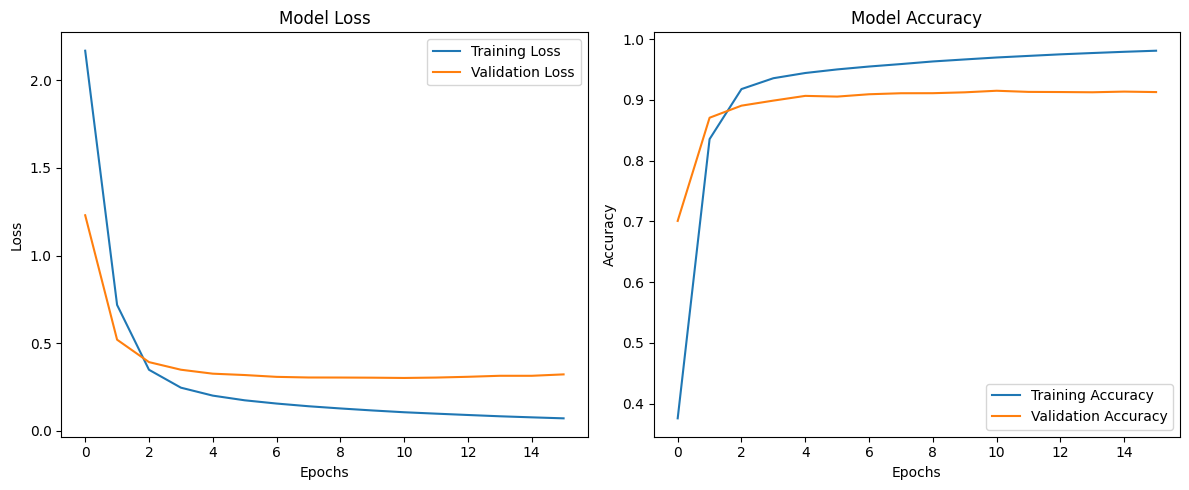

65/65 [==============================] - 7s 19ms/step - loss: 0.2821 - accuracy: 0.9168


In [24]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [21]:
eng_tagger.save_model(model_filename = "units16")

Model saved in ./models/units16.keras
Training history saved in ./models/units16_training_history.json


We will make a last experiment increasing the number of units to 128.

In [25]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 128, 
#     output_dim = 50, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("units128")

# To train the model
# eng_tagger.train(
#     batch_size = 64, 
#     optimizer = "adam", 
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/units128.keras
Epoch 1/11 - Loss: 1.5887, Accuracy: 0.5295, Val Loss: 0.5641, Val Accuracy: 0.8467
Epoch 2/11 - Loss: 0.3340, Accuracy: 0.9090, Val Loss: 0.3425, Val Accuracy: 0.9028
Epoch 3/11 - Loss: 0.1945, Accuracy: 0.9441, Val Loss: 0.3085, Val Accuracy: 0.9088
Epoch 4/11 - Loss: 0.1510, Accuracy: 0.9546, Val Loss: 0.2866, Val Accuracy: 0.9157
Epoch 5/11 - Loss: 0.1261, Accuracy: 0.9613, Val Loss: 0.2826, Val Accuracy: 0.9170
Epoch 6/11 - Loss: 0.1073, Accuracy: 0.9672, Val Loss: 0.2801, Val Accuracy: 0.9200
Epoch 7/11 - Loss: 0.0921, Accuracy: 0.9721, Val Loss: 0.2919, Val Accuracy: 0.9177
Epoch 8/11 - Loss: 0.0796, Accuracy: 0.9762, Val Loss: 0.2982, Val Accuracy: 0.9175
Epoch 9/11 - Loss: 0.0677, Accuracy: 0.9806, Val Loss: 0.3073, Val Accuracy: 0.9189
Epoch 10/11 - Loss: 0.0593, Accuracy: 0.9831, Val Loss: 0.3234, Val Accuracy: 0.9173
Epoch 11/11 - Loss: 0.0499, Accuracy: 0.9863, Val Loss: 0.3423, Val Accuracy: 0.9158


We see that the difference between the loss in the training and validation sets is higher than in the previous models. Increasing the number of units to a high number may lead to overfitting, as the model can adapt better to the training set and have worse results in the validation set.

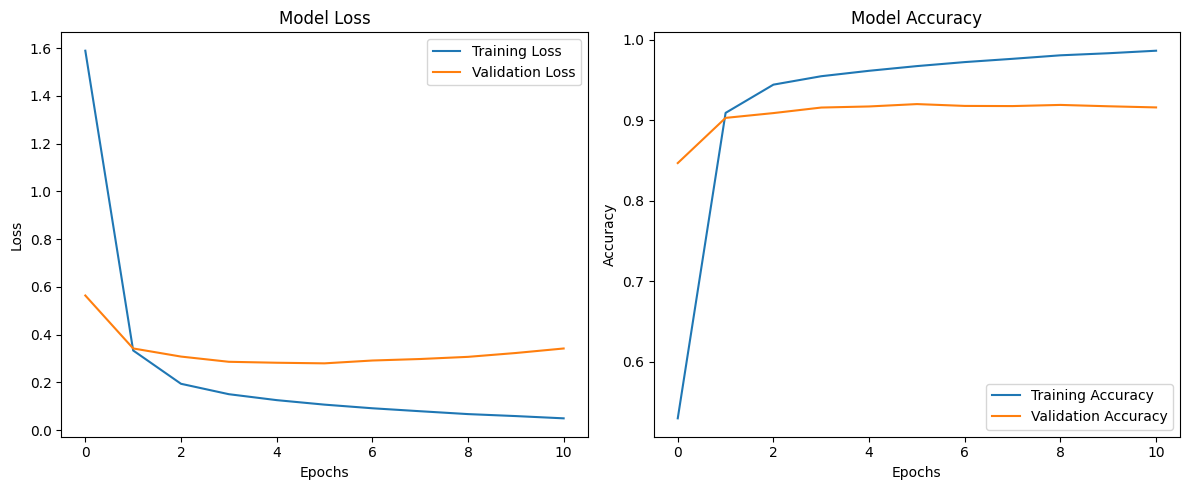

65/65 [==============================] - 12s 64ms/step - loss: 0.2569 - accuracy: 0.9221


In [26]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [27]:
eng_tagger.save_model(model_filename = "units128")

Model saved in ./models/units128.keras
Training history saved in ./models/units128_training_history.json


Comparing the results of the models with different number of units, we see that the model with 64 units has the best performance in the test set. The models with less units have worse results, while the model with 128 units has a higher difference between the loss in the training and validation sets.

In [ ]:
fig = add_curve(json_file = "models/units16_training_history.json", name = "16 units", color = "blue", title = "Number of units")
fig = add_curve(json_file = "models/units32_training_history.json", name = "32 units", color = "red", fig = fig)
fig = add_curve(json_file = "models/bidirectional_model_training_history.json", name = "64 units", color = "green", fig = fig)
fig = add_curve(json_file = "models/units128_training_history.json", name = "128 units", color = "orange", fig = fig)
fig.show()

| **Units** | **Acccuracy** | **Loss** |
|:---------:|:-------------:|:--------:|
|     16    |     0.9168    |  0.2821  |
|     32    |     0.9191    |  0.2736  |
|     64    |     0.9221    |  0.2598  |
|    128    |     0.9221    |  0.2569  |

### Embedding size

After changing the model complexity by changing the number of LSTM units, we can try to change the embedding size. We will try to increase the embedding size to 100 and to 200 and reduce it to 25.

In [28]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 64, 
#     output_dim = 100, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("embed100")

# To train the model
# eng_tagger.train(
#     batch_size = 64, 
#     optimizer = "adam", 
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/embed100.keras
Epoch 1/11 - Loss: 1.5046, Accuracy: 0.5728, Val Loss: 0.4821, Val Accuracy: 0.8697
Epoch 2/11 - Loss: 0.2815, Accuracy: 0.9233, Val Loss: 0.3161, Val Accuracy: 0.9057
Epoch 3/11 - Loss: 0.1770, Accuracy: 0.9483, Val Loss: 0.2862, Val Accuracy: 0.9140
Epoch 4/11 - Loss: 0.1405, Accuracy: 0.9579, Val Loss: 0.2785, Val Accuracy: 0.9166
Epoch 5/11 - Loss: 0.1166, Accuracy: 0.9649, Val Loss: 0.2954, Val Accuracy: 0.9133
Epoch 6/11 - Loss: 0.0988, Accuracy: 0.9705, Val Loss: 0.2765, Val Accuracy: 0.9186
Epoch 7/11 - Loss: 0.0828, Accuracy: 0.9760, Val Loss: 0.2849, Val Accuracy: 0.9172
Epoch 8/11 - Loss: 0.0704, Accuracy: 0.9799, Val Loss: 0.2913, Val Accuracy: 0.9183
Epoch 9/11 - Loss: 0.0601, Accuracy: 0.9834, Val Loss: 0.3017, Val Accuracy: 0.9184
Epoch 10/11 - Loss: 0.0509, Accuracy: 0.9864, Val Loss: 0.3166, Val Accuracy: 0.9166
Epoch 11/11 - Loss: 0.0430, Accuracy: 0.9889, Val Loss: 0.3343, Val Accuracy: 0.9179


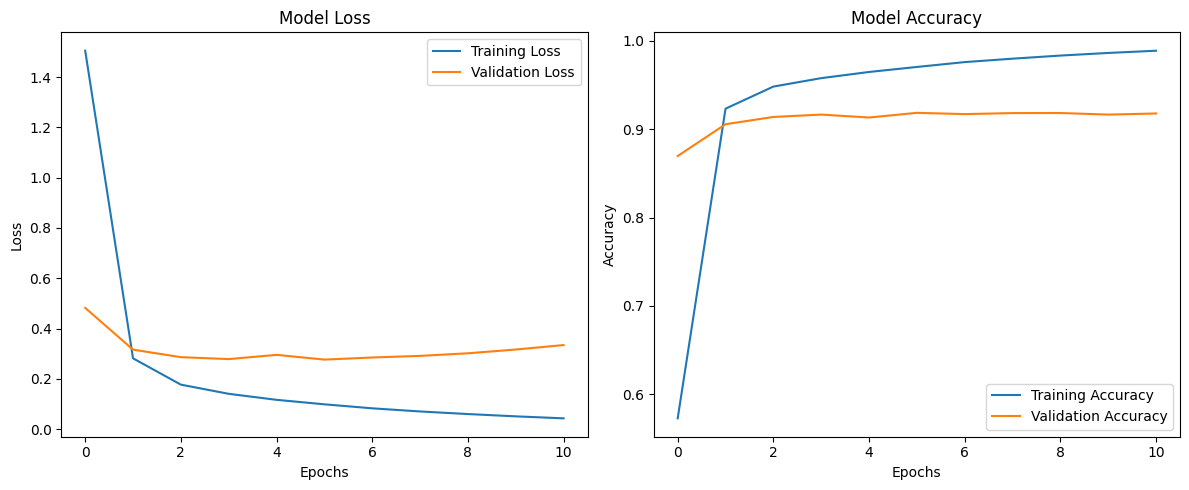

65/65 [==============================] - 11s 31ms/step - loss: 0.2576 - accuracy: 0.9218


In [29]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [27]:
eng_tagger.save_model(model_filename = "embed100")

Model saved in ./models/embed100.keras
Training history saved in ./models/embed100_training_history.json


In [30]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 64, 
#     output_dim = 200, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("embed200")

# To train the model
# eng_tagger.train(
#     batch_size = 64, 
#     optimizer = "adam", 
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/embed200.keras
Epoch 1/9 - Loss: 1.3251, Accuracy: 0.6212, Val Loss: 0.4101, Val Accuracy: 0.8844
Epoch 2/9 - Loss: 0.2362, Accuracy: 0.9334, Val Loss: 0.3082, Val Accuracy: 0.9081
Epoch 3/9 - Loss: 0.1534, Accuracy: 0.9536, Val Loss: 0.2847, Val Accuracy: 0.9151
Epoch 4/9 - Loss: 0.1212, Accuracy: 0.9628, Val Loss: 0.2761, Val Accuracy: 0.9175
Epoch 5/9 - Loss: 0.0985, Accuracy: 0.9701, Val Loss: 0.2809, Val Accuracy: 0.9192
Epoch 6/9 - Loss: 0.0814, Accuracy: 0.9756, Val Loss: 0.2949, Val Accuracy: 0.9178
Epoch 7/9 - Loss: 0.0670, Accuracy: 0.9806, Val Loss: 0.3043, Val Accuracy: 0.9180
Epoch 8/9 - Loss: 0.0554, Accuracy: 0.9844, Val Loss: 0.3272, Val Accuracy: 0.9171
Epoch 9/9 - Loss: 0.0459, Accuracy: 0.9877, Val Loss: 0.3251, Val Accuracy: 0.9182


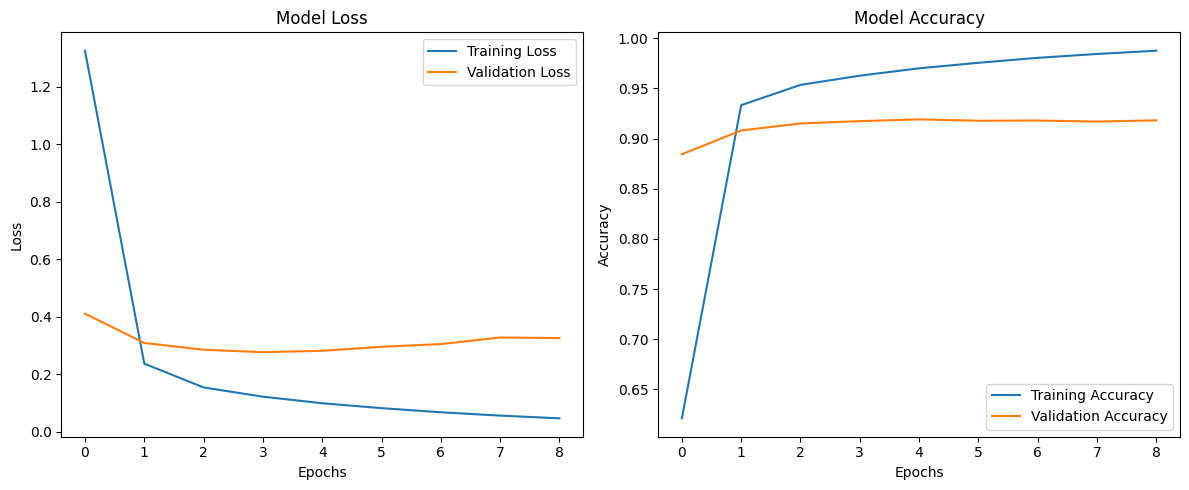

65/65 [==============================] - 3s 39ms/step - loss: 0.2566 - accuracy: 0.9205


In [29]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [30]:
eng_tagger.save_model(model_filename = "embed200")

Model saved in ./models/embed200.keras
Training history saved in ./models/embed200_training_history.json


In [36]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 64, 
#     output_dim = 25, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("embed25")

# To train the model
# eng_tagger.train(
#     batch_size = 64, 
#     optimizer = "adam", 
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/embed25.keras
Epoch 1/11 - Loss: 2.0415, Accuracy: 0.3886, Val Loss: 0.9601, Val Accuracy: 0.7201
Epoch 2/11 - Loss: 0.5380, Accuracy: 0.8493, Val Loss: 0.4189, Val Accuracy: 0.8824
Epoch 3/11 - Loss: 0.2651, Accuracy: 0.9276, Val Loss: 0.3330, Val Accuracy: 0.9031
Epoch 4/11 - Loss: 0.1940, Accuracy: 0.9445, Val Loss: 0.3062, Val Accuracy: 0.9090
Epoch 5/11 - Loss: 0.1609, Accuracy: 0.9532, Val Loss: 0.2973, Val Accuracy: 0.9118
Epoch 6/11 - Loss: 0.1413, Accuracy: 0.9585, Val Loss: 0.2880, Val Accuracy: 0.9136
Epoch 7/11 - Loss: 0.1256, Accuracy: 0.9631, Val Loss: 0.2949, Val Accuracy: 0.9138
Epoch 8/11 - Loss: 0.1127, Accuracy: 0.9669, Val Loss: 0.2895, Val Accuracy: 0.9159
Epoch 9/11 - Loss: 0.1019, Accuracy: 0.9704, Val Loss: 0.2945, Val Accuracy: 0.9157
Epoch 10/11 - Loss: 0.0918, Accuracy: 0.9736, Val Loss: 0.2961, Val Accuracy: 0.9163
Epoch 11/11 - Loss: 0.0818, Accuracy: 0.9769, Val Loss: 0.3015, Val Accuracy: 0.9175


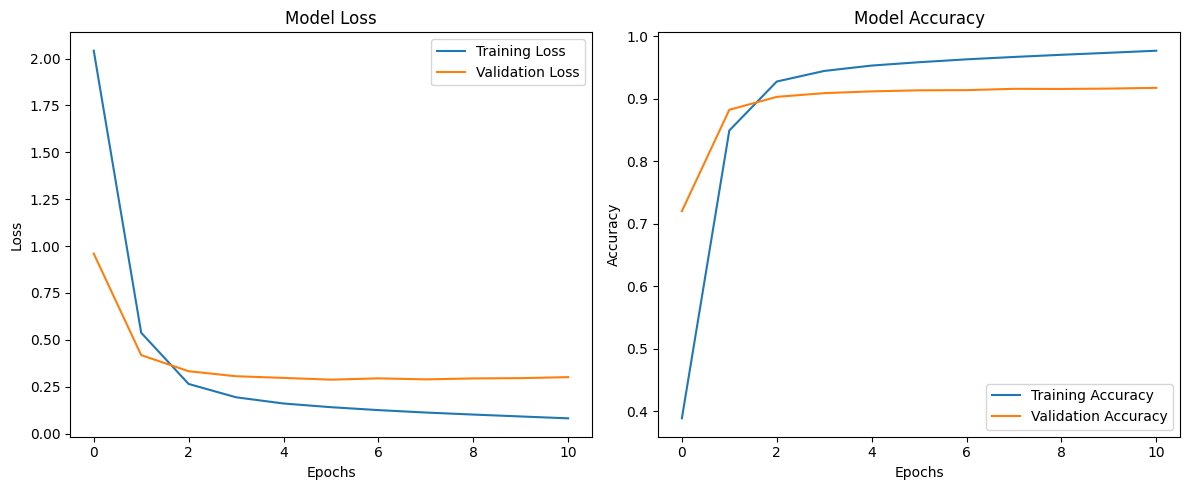

65/65 [==============================] - 8s 21ms/step - loss: 0.2709 - accuracy: 0.9192


In [37]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [35]:
eng_tagger.save_model(model_filename = "embed25")

Model saved in ./models/embed25.keras
Training history saved in ./models/embed25_training_history.json


When increasing the embedding size, we get a similar behavior to the one observed when increasing the number of units. As we increase the embedding size, the model starts to overfit, thanks to the complexity of the model. When reducing the embedding size, the model complexity is not enough to learn the patterns in the data, so the model performance is worse. As a consequence of this, we will choose the model with an embedding size of 50.

In [47]:

fig = add_curve(json_file = "models/embed25_training_history.json", name = "Dimension 25", color = "red", title = "Embedding dimension")
fig = add_curve(json_file = "models/bidirectional_model_training_history.json", name = "Dimension 50", color = "green", fig = fig)
fig = add_curve(json_file = "models/embed100_training_history.json", name = "Dimension 100", color = "orange", fig = fig)
fig = add_curve(json_file = "models/embed200_training_history.json", name = "Dimension 200", color = "blue", fig = fig)
fig.show()

| **Embedding dimension** | **Acccuracy** | **Loss** |
|:-----------------------:|:-------------:|:--------:|
|            15           |     0.9192    |  0.2709  |
|            50           |     0.9221    |  0.2598  |
|           100           |     0.9218    |  0.2576  |
|           200           |     0.9205    |  0.2566  |

### Batch size

Although the results are pretty good, we still have some overfitting in the model. One way to reduce overfitting is to increase the batch size. In this way, the model will learn from more examples at the same time in each iteration, focusing less in specific examples. We will try to increase the batch size to 128 and 256.

In [38]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 64, 
#     output_dim = 50, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("batch128")

# eng_tagger.train(
#     batch_size = 128, 
#     optimizer = "adam", 
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/batch128.keras
Epoch 1/15 - Loss: 2.4051, Accuracy: 0.2729, Val Loss: 1.7840, Val Accuracy: 0.5248
Epoch 2/15 - Loss: 0.9735, Accuracy: 0.7471, Val Loss: 0.5577, Val Accuracy: 0.8609
Epoch 3/15 - Loss: 0.3543, Accuracy: 0.9105, Val Loss: 0.3679, Val Accuracy: 0.8978
Epoch 4/15 - Loss: 0.2285, Accuracy: 0.9384, Val Loss: 0.3190, Val Accuracy: 0.9068
Epoch 5/15 - Loss: 0.1808, Accuracy: 0.9486, Val Loss: 0.3049, Val Accuracy: 0.9101
Epoch 6/15 - Loss: 0.1544, Accuracy: 0.9552, Val Loss: 0.2923, Val Accuracy: 0.9103
Epoch 7/15 - Loss: 0.1355, Accuracy: 0.9604, Val Loss: 0.2889, Val Accuracy: 0.9141
Epoch 8/15 - Loss: 0.1206, Accuracy: 0.9646, Val Loss: 0.2873, Val Accuracy: 0.9145
Epoch 9/15 - Loss: 0.1079, Accuracy: 0.9685, Val Loss: 0.2863, Val Accuracy: 0.9155
Epoch 10/15 - Loss: 0.0965, Accuracy: 0.9720, Val Loss: 0.2857, Val Accuracy: 0.9169
Epoch 11/15 - Loss: 0.0871, Accuracy: 0.9751, Val Loss: 0.2984, Val Accuracy: 0.9159
Epoch 12/15 - Loss: 0.0778, Accu

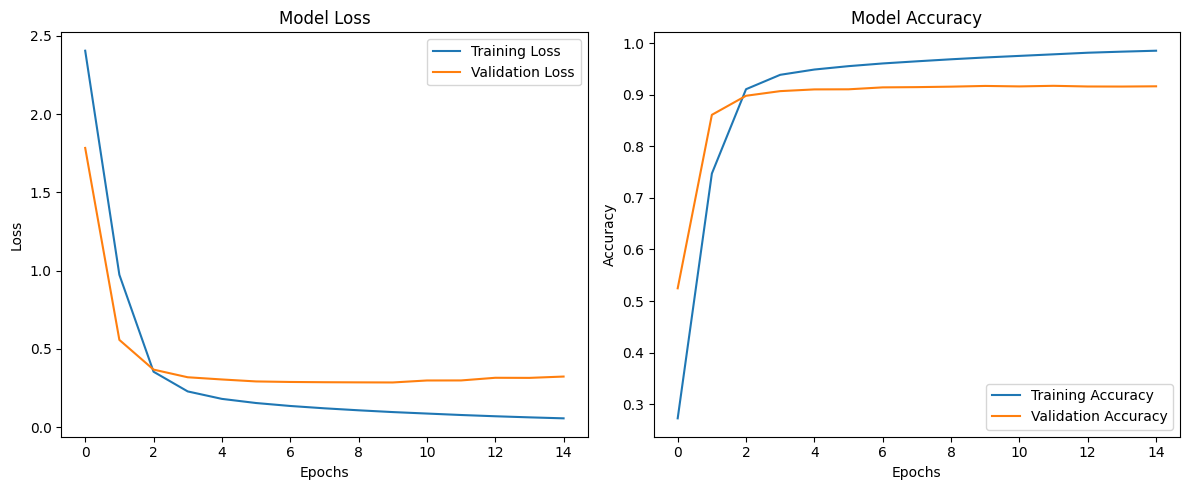

65/65 [==============================] - 10s 34ms/step - loss: 0.2738 - accuracy: 0.9185


In [39]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [33]:
eng_tagger.save_model(model_filename = "batch128")

Model saved in ./models/batch128.keras
Training history saved in ./models/batch128_training_history.json


In [40]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 64, 
#     output_dim = 50, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("batch256")

# To train the model
# eng_tagger.train(
#     batch_size = 256, 
#     optimizer = "adam", 
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/batch256.keras
Epoch 1/16 - Loss: 2.6417, Accuracy: 0.1886, Val Loss: 2.4284, Val Accuracy: 0.2492
Epoch 2/16 - Loss: 2.1310, Accuracy: 0.3627, Val Loss: 1.6667, Val Accuracy: 0.5727
Epoch 3/16 - Loss: 1.1016, Accuracy: 0.7324, Val Loss: 0.7444, Val Accuracy: 0.8143
Epoch 4/16 - Loss: 0.4937, Accuracy: 0.8875, Val Loss: 0.4597, Val Accuracy: 0.8817
Epoch 5/16 - Loss: 0.3081, Accuracy: 0.9252, Val Loss: 0.3747, Val Accuracy: 0.8960
Epoch 6/16 - Loss: 0.2351, Accuracy: 0.9399, Val Loss: 0.3406, Val Accuracy: 0.9027
Epoch 7/16 - Loss: 0.1963, Accuracy: 0.9470, Val Loss: 0.3211, Val Accuracy: 0.9068
Epoch 8/16 - Loss: 0.1718, Accuracy: 0.9516, Val Loss: 0.3098, Val Accuracy: 0.9085
Epoch 9/16 - Loss: 0.1535, Accuracy: 0.9561, Val Loss: 0.3011, Val Accuracy: 0.9109
Epoch 10/16 - Loss: 0.1392, Accuracy: 0.9597, Val Loss: 0.2944, Val Accuracy: 0.9120
Epoch 11/16 - Loss: 0.1269, Accuracy: 0.9635, Val Loss: 0.2887, Val Accuracy: 0.9148
Epoch 12/16 - Loss: 0.1171, Accu

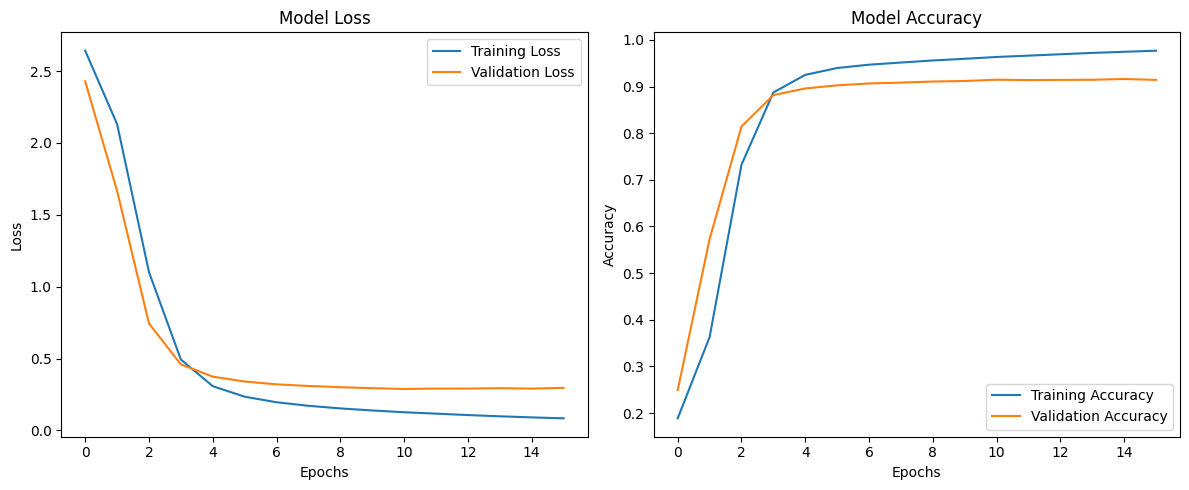

65/65 [==============================] - 7s 26ms/step - loss: 0.2744 - accuracy: 0.9200


In [41]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [36]:
eng_tagger.save_model(model_filename = "batch256")

Model saved in ./models/batch256.keras
Training history saved in ./models/batch256_training_history.json


We see that when increasing the batch size, the number of epochs trained increase as the model takes longer to converge. We also see that the difference between the loss in the training and validation sets reduces as we increase the batch size.

We will do a last experiment reducing the batch size to 32 in order to see how the model behaves with a smaller batch size.

In [42]:
# To create the model
# eng_tagger.build_model(
#     vocabulary_size = 10000, 
#     units = 64, 
#     output_dim = 50, 
#     bidirectional = True
# )
# To load the same model already trained
eng_tagger.load_model("batch32")

# To train the model
# eng_tagger.train(
#     batch_size = 32, 
#     optimizer = "adam", 
#     metrics=["accuracy"]
# )
# To show the training history of the model already trained
eng_tagger.show_training_log()

Model loaded from ./models/batch32.keras
Epoch 1/9 - Loss: 1.1765, Accuracy: 0.6581, Val Loss: 0.4097, Val Accuracy: 0.8858
Epoch 2/9 - Loss: 0.2403, Accuracy: 0.9318, Val Loss: 0.3075, Val Accuracy: 0.9095
Epoch 3/9 - Loss: 0.1618, Accuracy: 0.9511, Val Loss: 0.2824, Val Accuracy: 0.9163
Epoch 4/9 - Loss: 0.1311, Accuracy: 0.9596, Val Loss: 0.2788, Val Accuracy: 0.9162
Epoch 5/9 - Loss: 0.1101, Accuracy: 0.9662, Val Loss: 0.2916, Val Accuracy: 0.9160
Epoch 6/9 - Loss: 0.0927, Accuracy: 0.9719, Val Loss: 0.2872, Val Accuracy: 0.9175
Epoch 7/9 - Loss: 0.0789, Accuracy: 0.9766, Val Loss: 0.3039, Val Accuracy: 0.9161
Epoch 8/9 - Loss: 0.0663, Accuracy: 0.9807, Val Loss: 0.3212, Val Accuracy: 0.9159
Epoch 9/9 - Loss: 0.0565, Accuracy: 0.9841, Val Loss: 0.3294, Val Accuracy: 0.9160


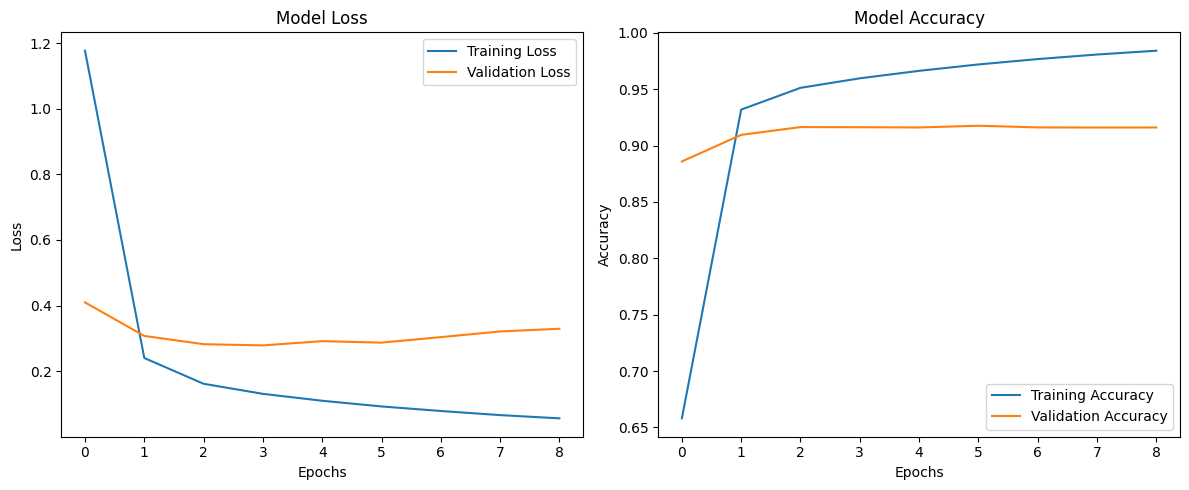

65/65 [==============================] - 9s 26ms/step - loss: 0.2629 - accuracy: 0.9187


In [43]:
eng_tagger.plot_training_history()
eng_tagger.evaluate()

In [39]:
eng_tagger.save_model(model_filename = "batch32")

Model saved in ./models/batch32.keras
Training history saved in ./models/batch32_training_history.json


In general, we see that when increasing the batch size, the model takes longer to converge and the difference between the loss in the training and validation sets is smaller. However, the validation loss is not reduced and the train loss is slightly increased. This suggests that the model is not able to learn the patterns in the data with a high batch size and it neither can generalize well with a small batch size.

The best results are for the smaller batches, 32 and 64. We will choose the model with a batch size of 64 as it has the best performance in the test set.

In [50]:
fig = add_curve(json_file = "models/batch32_training_history.json", name = "Batch 32", color = "red", title = "Batch size")
fig = add_curve(json_file = "models/bidirectional_model_training_history.json", name = "Batch 64", color = "green", fig=fig)
fig = add_curve(json_file = "models/batch128_training_history.json", name = "Batch 128", color = "orange", fig = fig)
fig = add_curve(json_file = "models/batch256_training_history.json", name = "Batch 256", color = "blue", fig = fig)
fig.show()

| **Batch size** | **Acccuracy** | **Loss** |
|:--------------:|:-------------:|:--------:|
|       32       |     0.9187    |  0.2629  |
|       64       |     0.9218    |  0.2576  |
|       128      |     0.9185    |  0.2738  |
|       256      |     0.9200    |  0.2744  |

## Best model

Parameters of the best model (bidirectional_model):
- `Vocabulary size`: 10,000
- `Embedding size`: 50
- `LSTM units`: 64
- `Bidirectional`: True
- `Batch size`: 64

To end this notebook, we will analyze the results obtined by the best model. We will plot the confusion matrix and analyze the results. In the confussion matrix we can see the same problems we have with the initial model but with less cases, thanks to the bidirectional layer. The tag 'X' is never predicted correctly as these are strange words with few representation. The confussion between 'NOUN' and 'PROPN' is still very common, but the number of errors is lower than in the initial model. The tag 'NOUN' is the most frequent tag in the dataset, which may explain the high number of errors with other classes like 'ADJ' or 'VERB'.

Model loaded from ./models/bidirectional_model.keras
65/65 [==============================] - 4s 24ms/step


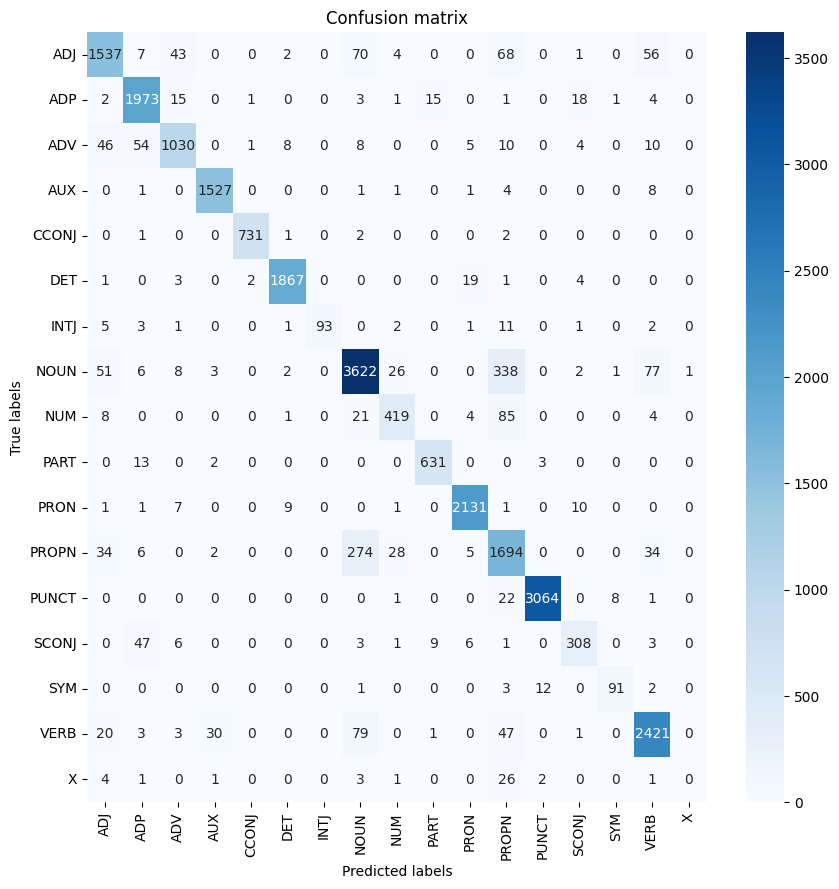

In [44]:
eng_tagger.load_model("bidirectional_model")
eng_tagger.evaluate()
eng_tagger.plot_confusion_matrix()